In [1]:
# pip install pandas==1.3.4
# pip install json==2.0.9
# pip install gensim==4.1.2
# pip install matplotlib==3.4.3
# pip install seaborn==0.11.2
# pip install nltk==3.6.5
# pip install scikit-learn==1.0.2

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\areeb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
# Load data
# df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/combined.json', lines=True)
df = pd.read_json("combined.json" , lines = True)
# Define a function to preprocess the text data
df.head(5)

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    my_stopwords = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in my_stopwords])
    # Stem the words
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    text = ' '.join(stemmed_words)
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(lemmatized_words)
    return text

In [7]:
# Apply the preprocessing function to the text column
df['contents'] = df['contents'].apply(preprocess_text)


In [8]:
df.head(5)

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,portland oregon – moham osman mohamud convict ...,2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,washington – north carolina waccamaw river wat...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,boston– million settlement reach natur resourc...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,washington—a feder grand juri la vega today re...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,u depart justic u environment protect agenc ep...,2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


In [9]:
print(df.columns)

Index(['id', 'title', 'contents', 'date', 'topics', 'components'], dtype='object')


In [10]:
df["topics"].head(20)

0                        []
1                        []
2                        []
3                        []
4             [Environment]
5                        []
6                        []
7     [Consumer Protection]
8                        []
9                        []
10                       []
11                       []
12                       []
13                       []
14                       []
15                       []
16                       []
17                       []
18                       []
19            [Environment]
Name: topics, dtype: object

In [11]:
df = df[df['topics'].apply(lambda x: len(x) > 0)]

In [12]:
df["topics"]

4                                            [Environment]
7                                    [Consumer Protection]
19                                           [Environment]
22                   [False Claims Act, Health Care Fraud]
23                   [Health Care Fraud, False Claims Act]
                               ...                        
13081                                        [Hate Crimes]
13082                                        [Environment]
13084                                 [Foreign Corruption]
13085    [Asset Forfeiture, Counterintelligence and Exp...
13086             [Counterintelligence and Export Control]
Name: topics, Length: 4688, dtype: object

In [13]:
# Define the vectorizer
cv = CountVectorizer(stop_words='english')

# Create the document-term matrix
dtm = cv.fit_transform(df['contents'])

# Define the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)


In [14]:
# Fit the LDA model to the document-term matrix
lda.fit(dtm)

LatentDirichletAllocation(random_state=42)

In [15]:
# Define a function to print the top words for each topic
def get_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_name = ' '.join(words)
        topics.append(topic_name)
    return topics

In [16]:
unique_topics = list(set([item for sublist in df['topics'].tolist() for item in sublist]))
print(len(unique_topics))

42


In [17]:
# Print the top words for each topic
top_words = get_top_words(lda, cv.get_feature_names_out(), 10)

In [18]:

# Define a function to extract topic names from the top_words list
def extract_topic_names(top_words):
    topic_names = list(set([item for sublist in df['topics'].tolist() for item in sublist]))
    return topic_names

In [19]:

# Extract the topic names from the top_words list
topic_names = extract_topic_names(top_words)

# Print the topic names in the specified format
for i, name in enumerate(topic_names):
    print(f"Topic #{i}: {name}")

Topic #0: Bankruptcy
Topic #1: Consumer Protection
Topic #2: Intellectual Property
Topic #3: Prescription Drugs
Topic #4: Counterintelligence and Export Control
Topic #5: Public Corruption
Topic #6: Human Smuggling
Topic #7: Human Trafficking
Topic #8: Cyber Crime
Topic #9: Community Outreach
Topic #10: Access to Justice
Topic #11: Indian Country Law and Justice
Topic #12: Opioids
Topic #13: Firearms Offenses
Topic #14: Project Safe Childhood
Topic #15: Wildlife
Topic #16: Financial Fraud
Topic #17: Grants
Topic #18: Counterterrorism
Topic #19: National Security
Topic #20: Securities, Commodities, & Investment Fraud
Topic #21: Elder Justice
Topic #22: Antitrust
Topic #23: Hate Crimes
Topic #24: False Claims Act
Topic #25: Identity Theft
Topic #26: Disaster Fraud
Topic #27: Violent Crime
Topic #28: Foreign Corruption
Topic #29: Asset Forfeiture
Topic #30: Health Care Fraud
Topic #31: Civil Rights
Topic #32: Labor & Employment
Topic #33: Tax
Topic #34: StopFraud
Topic #35: Immigration
To

In [20]:
import pandas as pd
import json
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re

In [21]:
# Load the JSON data
# df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/combined.json', lines=True)
df = pd.read_json("combined.json" , lines = True)
# Extract the press releases and publication dates
documents = df['contents'].tolist()
dates = pd.to_datetime(df['date']).tolist()

In [22]:
# Define stopwords and stemmer
my_stopwords = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords and stem the words
    words = [stemmer.stem(word) for word in words if word not in my_stopwords]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

In [23]:
# Preprocess the documents
texts = [preprocess_text(document) for document in documents]

In [25]:
topic_names

['Bankruptcy',
 'Consumer Protection',
 'Intellectual Property',
 'Prescription Drugs',
 'Counterintelligence and Export Control',
 'Public Corruption',
 'Human Smuggling',
 'Human Trafficking',
 'Cyber Crime',
 'Community Outreach',
 'Access to Justice',
 'Indian Country Law and Justice',
 'Opioids',
 'Firearms Offenses',
 'Project Safe Childhood',
 'Wildlife',
 'Financial Fraud',
 'Grants',
 'Counterterrorism',
 'National Security',
 'Securities, Commodities, & Investment Fraud',
 'Elder Justice',
 'Antitrust',
 'Hate Crimes',
 'False Claims Act',
 'Identity Theft',
 'Disaster Fraud',
 'Violent Crime',
 'Foreign Corruption',
 'Asset Forfeiture',
 'Health Care Fraud',
 'Civil Rights',
 'Labor & Employment',
 'Tax',
 'StopFraud',
 'Immigration',
 'Environment',
 'Mortgage Fraud',
 'Office and Personnel Updates',
 'Servicemembers Initiative',
 'Drug Trafficking',
 'Project Safe Neighborhoods']

In [26]:
# Create a dictionary and bag-of-words representation of the documents
dictionary = corpora.Dictionary([text.split() for text in texts])
corpus = [dictionary.doc2bow(text.split()) for text in texts]


In [27]:

# Train the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=42, id2word=dictionary, passes=10)


In [29]:
# Get the topic weights for each document
topic_weights = []
for i, doc in enumerate(corpus):
    doc_topics = lda_model.get_document_topics(doc)
    topic_weights.append([t[1] for t in doc_topics])

In [30]:
# Combine the topic weights with the publication dates
df = pd.DataFrame(topic_weights, columns=[f'Topic {i}' for i in topic_names])
df['date'] = pd.to_datetime(dates, utc=True)

In [31]:
# Group the dataframe by year and sum the topic weights
df['Year'] = df['date'].dt.year
df_grouped = df.groupby('Year').sum()

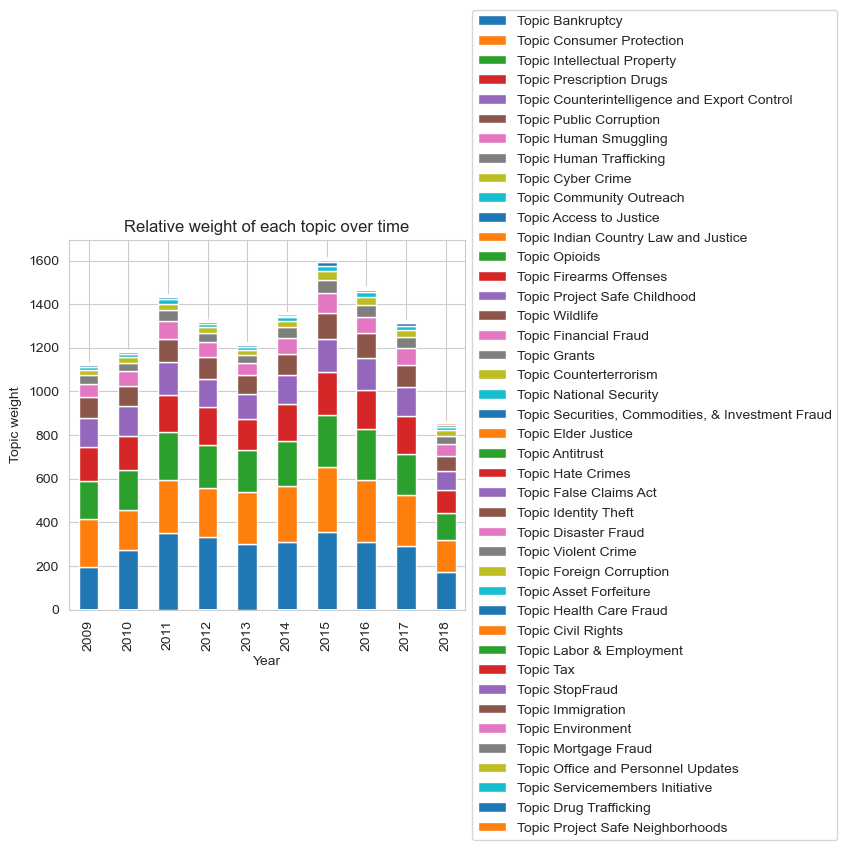

In [32]:
# Plot the relative weight of each topic over time
sns.set_style('whitegrid')
ax = df_grouped.plot(kind='bar', stacked=True)
plt.title('Relative weight of each topic over time')
plt.xlabel('Year')
plt.ylabel('Topic weight')

# Display the legend outside of the chart
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()